In [1]:
from pathlib import Path
import pystac
from pystac import CatalogType
import numpy as np
import scipy
import matplotlib.pyplot as plt
import h5py
import pandas as pd
import cartopy.crs as ccrs
import pathlib
import re
import json

from shapely.geometry import LineString, mapping, Point
from shapely import bounds

In [2]:
from pystac.extensions.projection import AssetProjectionExtension
from pystac_client import Client
import stac_geoparquet

In [3]:
import datetime as dt
import geopandas as gpd
import shapely

In [4]:
epsg_3413 = ccrs.Stereographic(central_longitude=0, central_latitude=90, false_easting=0, false_northing=0, globe=None)
epsg_3031 = ccrs.Stereographic(central_longitude=0, central_latitude=-90, false_easting=0, false_northing=0, globe=None)

## Define the catalog

We need a catalog to items into. For now, I'm disabling all extentions except for `projection` and `file` while I prototype basic search and metadata structure.

In [5]:
# Base catalog

catalog = pystac.Catalog(
    id='OPR',
    description='Open Polar Radar airbone data',
    stac_extensions=['https://stac-extensions.github.io/projection/v1.0.0/schema.json',
                     #'https://stac-extensions.github.io/scientific/v1.0.0/schema.json',
                     #'https://stac-extensions.github.io/processing/v1.2.0/schema.json',
                     #'https://stac-extensions.github.io/version/v1.2.0/schema.json',
                     'https://stac-extensions.github.io/file/v2.1.0/schema.json',]
)

# JSON Progress Check
print(json.dumps(catalog.to_dict(), indent=4))

{
    "type": "Catalog",
    "id": "OPR",
    "stac_version": "1.1.0",
    "description": "Open Polar Radar airbone data",
    "links": [],
    "stac_extensions": [
        "https://stac-extensions.github.io/projection/v1.0.0/schema.json",
        "https://stac-extensions.github.io/file/v2.1.0/schema.json"
    ]
}


### Function to pull out item level metadata

This will probably happen using the on prem postgis database in the future. We could also use just the cvs files to grab the data that we want; I'm calling and loading the underlying hdf data for two reasons:

  1. The time values seem to be correct there
  2. I want to make sure that we have both the csv and hdf files, and having the function take both will ensure we get an error when if we don't have both present



In [6]:
def make_stac_item(l1_hdf5_path, l2_csv_path):
    try:
        # for newer MATLAB files, use the h5py library
        f = h5py.File(l1_hdf5_path, 'r')
    except:
        # for older ones, we need to use scipy.io.loadmat
        f = scipy.io.loadmat(l1_hdf5_path, spmatrix=False)

    # extract time
    slow_time = np.squeeze(np.array(f['GPS_time']))
    date = dt.datetime.fromtimestamp(slow_time.mean())
    f.close()

    l2 = pd.read_csv(l2_csv_path)

    # extract the needed geometry info, prep for geojson
    geom_series = gpd.GeoSeries(map(Point, zip(l2.LON.values, l2.LAT.values)))
    line = LineString(geom_series.tolist())
    boundingbox = shapely.geometry.box(shapely.bounds(line)[0],
                                 shapely.bounds(line)[1],
                                 shapely.bounds(line)[2],
                                 shapely.bounds(line)[3])
    
    # Unsure about if we want the shape primative, or the mapping
    # I think STAC wants the mapping; but we may need the primatives for extent calcs
    return {
        'geom': line, #mapping(line),
        'bbox': boundingbox, #mapping(boundingbox),
        'date': date
    }

### Create items for 2016_Antarctica_DC8

These will all go in their own collection(s)-- i.e., either a collection per flight line, or a collection for the full year. Syntax for STAC is that *the items are created first* and ***then are added to a collection / catalogue.*** This creates a bit of ordering tension; we'd like to be able to add items to the collection or catalogue as we create them, but also need to pull out the space/time info to aggregate and define the spaciotemporal extent of the collection.

My guess is that we'll actually want these collections per flight line, so that we can have those flightline paths represented in the metadata when browsing. For that, we can either segment by DOY, or, by DOY split again by the underscores (which I assume are for multiple flights on a given day). The collection level decisions are less important than the schema, since we can create multiple 'collection views' with the dynamic API that allow different tree traversal pathways. For now, we're just adding files to two collections based on campaign, to make sure we're able to specify the hierarchy correctly.

We start with 2016 Antarctica DC8 data

In [7]:
base_dir = "/home/thomasteisberg/Documents/opr/opr_test_dataset_1/"

mapproj = epsg_3031
mat_path = base_dir + "2016_Antarctica_DC8/CSARP_standard/"

DC8_2016_items = []

#lines = {}
#mat_root = pathlib.Path(mat_path)

# Make a dictionary of CSV files by key
key_re = re.compile(r"(\d{8}_\d{2}_\d{3})")
csv_file_paths = {}
csv_path = base_dir + "2016_Antarctica_DC8/csv/"
csv_root = pathlib.Path(csv_path)

rel_root = "https://data.cresis.ku.edu/data/rds/"

# Hack for 'first' bbox
# We're going to union bboxes in the loop to get collection level bounds
# This manually instantiates the first one
bboxes = shapely.geometry.box(-70.150925, -71.885769, -70.117274, -71.292767)

# We also need a temporal extent
aqtimes = []

for csv_file in csv_root.rglob("2016*/*.csv"):
#for csv_file in csv_root.rglob("20161026*/*.csv"):
    h5data = mat_path + csv_file.name[5:16] + '/' + csv_file.name[:20] + '.mat'
    values = make_stac_item(h5data, csv_file)

    # expand the footprints for collection
    bboxes = bboxes.union(values['bbox'])
    aqtimes.append(values['date'])

    item = pystac.Item(
        id="CSARP_Standard_" + csv_file.name[5:20],
        geometry=mapping(values['geom']),
        #bbox=mapping(values['bbox']),
        bbox=values['bbox'].bounds,
        datetime=values['date'],
        # still debugging projection extention use
        # 'https://stac-extensions.github.io/projection/v1.0.0/schema.json',
        stac_extensions=['https://stac-extensions.github.io/file/v2.1.0/schema.json'],
        properties= {}
)
    thumb_path = rel_root + "2016_Antarctica_DC8/images/" + csv_file.name[5:16] + '/' + csv_file.name[5:20] + "_2echo_picks.jpg"
    #assert thumb_path.exists()

    item.add_asset(
        key='data',
        asset=pystac.Asset(
            href=rel_root + h5data[2:],
            media_type=pystac.MediaType.HDF5
        )
    )

    
    # Need to verify if this is projection for the data or metadata
    # Broken :-(
    ##asset_ext = AssetProjectionExtension.ext(item.assets['data'])
    ##asset_ext.epsg = 4326
    #asset_ext.shape = ds.shape
    ##asset_ext.bbox = mapping(values['bbox'])
    ##asset_ext.geometry = mapping(values['geom'])
    
    
    item.add_asset(
        key='thumbnails',
        asset=pystac.Asset(
            href=thumb_path, #.as_posix(),
            media_type=pystac.MediaType.JPEG
        )
    )

    # add the graphs

    flight_path = rel_root + "2016_Antarctica_DC8/images/" + csv_file.name[5:16] + '/' + csv_file.name[5:20] + "_0maps.jpg"
    #assert graph_path.exists()

    item.add_asset(
        key='flight_path',
        asset=pystac.Asset(
            href=flight_path, #.as_posix(),
            media_type=pystac.MediaType.JPEG
        )
    )

    DC8_2016_items.append(item)
    #collection1.add_item(item)
    ##catalog.add_item(item)

In [8]:
values['bbox'].exterior.coords.xy

(array('d', [-122.599503, -122.599503, -124.29926, -124.29926, -122.599503]),
 array('d', [-74.798368, -74.765181, -74.765181, -74.798368, -74.798368]))

### Pulling out aggregated collection level spaciotemporal metadata

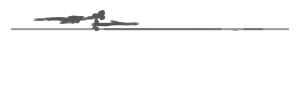

In [9]:
# Collection of granual bounding boxes
bboxes

In [10]:
bboxes.bounds

(-179.997402, -89.209755, 179.99879, -64.599907)

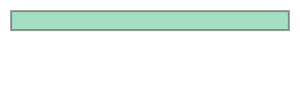

In [11]:
shapely.geometry.box(bboxes.bounds[0],
                     bboxes.bounds[1],
                     bboxes.bounds[2],
                     bboxes.bounds[3])

We can already see some of the polar weirdness from collections that cross over from negative to positive latitudes; per flight line segmenting will help here

In [12]:
# spatial coverage
collection_bbox = list(bboxes.bounds)
spatial_extent = pystac.SpatialExtent(bboxes=[collection_bbox])

# temporal coverage
collection_interval = sorted(aqtimes)
temporal_extent = pystac.TemporalExtent(intervals=[collection_interval[0],
                                                   collection_interval[-1]])

# combined spaciotemporal extent
collection_extent = pystac.Extent(spatial=spatial_extent, temporal=temporal_extent)

### Define the collection

In [13]:
collection1 = pystac.Collection(id='2016_Antarctica_DC8',
                                description='2016 DC8 Flights over Antarctica',
                                extent=collection_extent,
                                license='CC-BY-SA-4.0')

The next cell is commented for sanity when looking at the notebook on github... **but it does actaully need to run create the catalogue!**

In [ ]:
## Long output
collection1.add_items(DC8_2016_items)
len(collection1)

[<Link rel=item target=<Item id=CSARP_Standard_20161028_04_015>>,
 <Link rel=item target=<Item id=CSARP_Standard_20161028_04_003>>,
 <Link rel=item target=<Item id=CSARP_Standard_20161028_04_013>>,
 <Link rel=item target=<Item id=CSARP_Standard_20161028_04_033>>,
 <Link rel=item target=<Item id=CSARP_Standard_20161028_04_028>>,
 <Link rel=item target=<Item id=CSARP_Standard_20161028_04_005>>,
 <Link rel=item target=<Item id=CSARP_Standard_20161028_04_001>>,
 <Link rel=item target=<Item id=CSARP_Standard_20161028_04_024>>,
 <Link rel=item target=<Item id=CSARP_Standard_20161028_04_014>>,
 <Link rel=item target=<Item id=CSARP_Standard_20161028_04_023>>,
 <Link rel=item target=<Item id=CSARP_Standard_20161028_04_020>>,
 <Link rel=item target=<Item id=CSARP_Standard_20161028_04_029>>,
 <Link rel=item target=<Item id=CSARP_Standard_20161028_04_008>>,
 <Link rel=item target=<Item id=CSARP_Standard_20161028_04_006>>,
 <Link rel=item target=<Item id=CSARP_Standard_20161028_04_010>>,
 <Link rel

In [15]:
catalog.add_child(collection1)

<Link rel=child target=<Collection id=2016_Antarctica_DC8>>

In [16]:
print(json.dumps(catalog.to_dict(), indent=4))

{
    "type": "Catalog",
    "id": "OPR",
    "stac_version": "1.1.0",
    "description": "Open Polar Radar airbone data",
    "links": [
        {
            "rel": "child",
            "href": null,
            "type": "application/json"
        }
    ],
    "stac_extensions": [
        "https://stac-extensions.github.io/projection/v1.0.0/schema.json",
        "https://stac-extensions.github.io/file/v2.1.0/schema.json"
    ]
}


In [17]:
# Long output
DC8_2016_items[0].get_parent()

<Collection id=2016_Antarctica_DC8>

In [18]:
from pystac.layout import BestPracticesLayoutStrategy

In [19]:
catalog.normalize_and_save(root_href='./stac_catalog', 
                          catalog_type=pystac.CatalogType.SELF_CONTAINED)

In [20]:
# Writing the catalogue
catalog.normalize_hrefs('./stac_catalog')#, strategy=BestPracticesLayoutStrategy)
#catalog.save()
catalog.save(catalog_type=CatalogType.SELF_CONTAINED)

In [21]:
# Reading the catalogue
cat = pystac.Catalog.from_file('./stac_catalog/catalog.json')
cat

<Catalog id=OPR>

In [23]:
## Long output
catalog.describe()

* <Catalog id=OPR>
    * <Collection id=2016_Antarctica_DC8>
      * <Item id=CSARP_Standard_20161028_04_015>
      * <Item id=CSARP_Standard_20161028_04_003>
      * <Item id=CSARP_Standard_20161028_04_013>
      * <Item id=CSARP_Standard_20161028_04_033>
      * <Item id=CSARP_Standard_20161028_04_028>
      * <Item id=CSARP_Standard_20161028_04_005>
      * <Item id=CSARP_Standard_20161028_04_001>
      * <Item id=CSARP_Standard_20161028_04_024>
      * <Item id=CSARP_Standard_20161028_04_014>
      * <Item id=CSARP_Standard_20161028_04_023>
      * <Item id=CSARP_Standard_20161028_04_020>
      * <Item id=CSARP_Standard_20161028_04_029>
      * <Item id=CSARP_Standard_20161028_04_008>
      * <Item id=CSARP_Standard_20161028_04_006>
      * <Item id=CSARP_Standard_20161028_04_010>
      * <Item id=CSARP_Standard_20161028_04_032>
      * <Item id=CSARP_Standard_20161028_04_002>
      * <Item id=CSARP_Standard_20161028_04_017>
      * <Item id=CSARP_Standard_20161028_04_034>
      * 

In [24]:
## Long output
cat.describe()

* <Catalog id=OPR>
    * <Collection id=2016_Antarctica_DC8>
      * <Item id=CSARP_Standard_20161028_04_015>
      * <Item id=CSARP_Standard_20161028_04_003>
      * <Item id=CSARP_Standard_20161028_04_013>
      * <Item id=CSARP_Standard_20161028_04_033>
      * <Item id=CSARP_Standard_20161028_04_028>
      * <Item id=CSARP_Standard_20161028_04_005>
      * <Item id=CSARP_Standard_20161028_04_001>
      * <Item id=CSARP_Standard_20161028_04_024>
      * <Item id=CSARP_Standard_20161028_04_014>
      * <Item id=CSARP_Standard_20161028_04_023>
      * <Item id=CSARP_Standard_20161028_04_020>
      * <Item id=CSARP_Standard_20161028_04_029>
      * <Item id=CSARP_Standard_20161028_04_008>
      * <Item id=CSARP_Standard_20161028_04_006>
      * <Item id=CSARP_Standard_20161028_04_010>
      * <Item id=CSARP_Standard_20161028_04_032>
      * <Item id=CSARP_Standard_20161028_04_002>
      * <Item id=CSARP_Standard_20161028_04_017>
      * <Item id=CSARP_Standard_20161028_04_034>
      * 

## Viewing and interacting with the catalogue

Currently, the following services are used (outside of jupyter):

### A node server to serve the root directory of the STAC.

I've following [this advice](https://github.com/radiantearth/stacbrowser/blob/main/docs/local_files.md) and using `npx http-server -p 8000 --cors` to do this, which avoids having to install anything ([more details on the server](https://www.npmjs.com/package/http-server)). Make you that you `cd stac_catalog` , or where ever the root of the STAC is prior to starting the node server.

### The stac browser

Clone [the repo and follow instructions](https://github.com/radiantearth/stac-browser) to install. Running from the cloned repo post install is easiest, since all the supporting files are in the path; this is how I start the browser:

```bash
npm start -- --open --catalogUrl="http://127.0.0.1:8000/catalog.json" 
```

The `catalogUrl` I use is whatever *npx http-server* spins up. I initally had to add `--stacProxyUrl=/Users/espg/Desktop/Astera/testdata/opr_test_dataset_1/stac_catalog` to the command above, defining `stacProxyUrl` to match my stac_catalog filesystem path... however this seems to not be needed with how relative paths are saved now.

### Open in a (private) webrowser

If you're interating and making any changes to the STAC, chrome and other browser can fail to show you updates when they cache the json. To test and debug, I nuke the `stac_catalog` path after any update, restart both the npx and npm servers, and then copy the address from the window that npm launches into an incognito window.


# Searching the STAC (in progress)

## Converting to geoparquet

Mostly taken from [this example](https://stac-utils.github.io/stac-geoparquet/latest/examples/naip/)

In [25]:
items_iter = catalog.get_all_items()

mergepath = Path('./stac_all.json')

In [26]:
# write to single file path

with open(mergepath, 'w') as f:
    for item in items_iter:
        json.dump(item.to_dict(), f, separators=(",", ":"))
        f.write("\n")

In [27]:
record_batch_reader = stac_geoparquet.arrow.parse_stac_ndjson_to_arrow(mergepath)


In [28]:
table = record_batch_reader.read_all()
table.schema

assets: struct<data: struct<href: string, type: string>, flight_path: struct<href: string, type: string>, th (... 45 chars omitted)
  child 0, data: struct<href: string, type: string>
      child 0, href: string
      child 1, type: string
  child 1, flight_path: struct<href: string, type: string>
      child 0, href: string
      child 1, type: string
  child 2, thumbnails: struct<href: string, type: string>
      child 0, href: string
      child 1, type: string
bbox: struct<xmin: double, ymin: double, xmax: double, ymax: double>
  child 0, xmin: double
  child 1, ymin: double
  child 2, xmax: double
  child 3, ymax: double
collection: string
geometry: binary
  -- field metadata --
  ARROW:extension:name: 'geoarrow.wkb'
  ARROW:extension:metadata: '{"crs":{"$schema":"https://proj.org/schemas/' + 1380
id: string
links: list<item: struct<href: string, rel: string, type: string>>
  child 0, item: struct<href: string, rel: string, type: string>
      child 0, href: string
      child 1, 

In [29]:
parquet_path = "./stac_all.parquet"
stac_geoparquet.arrow.parse_stac_ndjson_to_parquet(mergepath, 
                                                   parquet_path)

In [ ]:
!du -csh ./stac_all.parquet

In [ ]:
!du -sch ./stac_all.json

### The fast-api server for serving (using geoparquet)

See [here](https://github.com/stac-utils/stac-fastapi-geoparquet) for git project home.

Install is via pip (`stac-fastapi-geoparquet[serve]'`) ; start the server using: 

```shell
STAC_FASTAPI_GEOPARQUET_HREF=./stac_all.parquet uvicorn stac_fastapi.geoparquet.main:app
```


### The fast-api server for search (in progress)

This is a great way to see if your catalogue is valid... if you have invalid binary fields from improper item creation, things will error during search!

In [ ]:
# Port might need to be different to avoid collisions 
# if you still have stac-browser running...
fcat = Client.open('http://127.0.0.1:8000')

In [ ]:
fcat

In [ ]:
qq = fcat.search(
    #max_items=5,
    #bbox=[-72, -74 , -58, -61]
    bbox=[-70.150925, -71.885769, -70.117274, -71.292767]
)

In [ ]:
# Commented out because of the line geometry
# rendering on github
# qq.get_all_items()